# Link Prediction in NetworKit

## Setup

In [1]:
from networkit import *
%matplotlib inline
import matplotlib.pyplot as plt
import time
from sklearn import *
import numpy as np
import random

No module named 'seaborn'


In [2]:
cd ~/Thesis/NetworKit-Esders

/home/xza/Thesis/NetworKit-Esders


## Choose graph

In [3]:
G = readGraph("input/CA-CondMat.edgelist", Format.SNAP)

In [4]:
#properties.overview(G)

## Create training and test set

In [5]:
trainingGraph, testGraph = linkprediction.RandomEdgePartitioner(G).partitionByPercentage(0.3)
print(G.numberOfEdges(), "=>", trainingGraph.numberOfEdges(), "/", testGraph.numberOfEdges())

93497 => 65448 / 28049


In [6]:
missingLinks = linkprediction.UnconnectedNodesFinder(trainingGraph).findAll(2)
print("2-hop missing links in training graph:", len(missingLinks))

2-hop missing links in training graph: 772191


## Create link predictor instances

In [7]:
katzIndex = linkprediction.KatzIndex(trainingGraph, 5, 0.005)
commonNeighborsIndex = linkprediction.CommonNeighborsIndex(trainingGraph)
jaccardIndex = linkprediction.JaccardIndex(trainingGraph)
preferentialAttachmentIndex = linkprediction.PreferentialAttachmentIndex(trainingGraph)
adamicAdarIndex = linkprediction.AdamicAdarIndex(trainingGraph)

# Supervised Link Prediction

## Choose link predictors to use as feature-generators

In [8]:
linkPredictors = (commonNeighborsIndex, jaccardIndex, adamicAdarIndex)

## Create training set with negative instances

To train a classifier there has to be a specific training set with positive (link) and negative instances (absent link) which is mostly balanced.
To create this set we randomly pick a given number of positive instances from the trainingGraph. Then we randomly pick the same number of negative instances from the trainingGraph excluding


WARNING: Right now we generate a training set from edges in the test set! Fix this!

In [9]:
randomPos = testGraph.randomEdges(25000)
randomNeg = []
ind = 0
while len(randomNeg) < 25000:
    if not testGraph.hasEdge(missingLinks[ind][0], missingLinks[ind][1]):
        randomNeg.append(missingLinks[ind])
    ind += 1
merged = randomPos + randomNeg
random.shuffle(merged)
merged = np.array(merged)

nodePairsTrain = merged[:40000]
nodePairsTest = merged[-10000:]

classesTrain = linkprediction.getClasses(nodePairsTrain, testGraph)
classesTest = linkprediction.getClasses(nodePairsTest, testGraph)

samplesTest = linkprediction.getSamples(nodePairsTest, *linkPredictors)

In [10]:
dtc = tree.DecisionTreeClassifier()
linkprediction.trainClassifier(nodePairsTrain, testGraph, dtc, *linkPredictors)

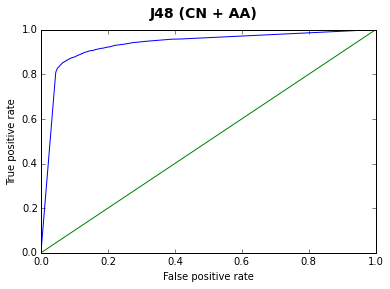

In [11]:
predictionsKNN = dtc.predict_proba(samplesTest)
isEdgePred = [x[1] for x in predictionsKNN]
#sum = 0
#for i in range(0, len(predictionsKNN)):
#    if predictionsKNN[i] == classesTest[i]:
#        sum +=1
#sum
fpr, tpr, thresholds = metrics.roc_curve(classesTest, isEdgePred)
plt.suptitle("J48 (CN + AA)", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1])

In [12]:
metrics.roc_auc_score(classesTest, isEdgePred)

0.93162322226578986

In [ ]:
start_time = time.time()
dyadScorePairs = katzIndex.runOnParallel(missingLinks)
linkprediction.KatzIndex.sortByScore(dyadScorePairs)
print("%s seconds" % (time.time() - start_time))

In [ ]:
dyadScorePairs[:10]

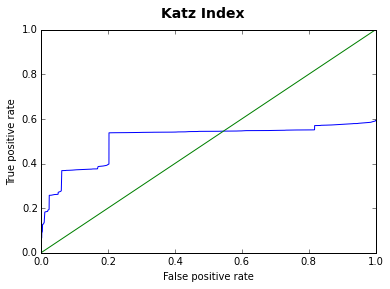

In [39]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [40]:
roc.areaUnderCurve()

0.5064284735999991

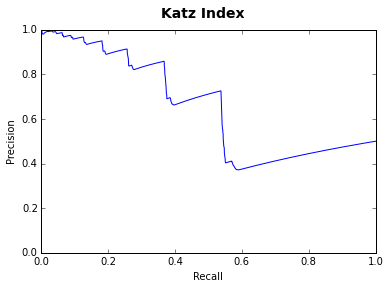

In [41]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Katz Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [42]:
pr.areaUnderCurve()

0.6584974377255697

In [13]:
start_time = time.time()
dyadScorePairs = commonNeighborsIndex.runOnParallel(missingLinks)
dyadScorePairs = linkprediction.CommonNeighborsIndex.sortByScore(dyadScorePairs)
print("%s seconds" % (time.time() - start_time))

1.0622262954711914 seconds


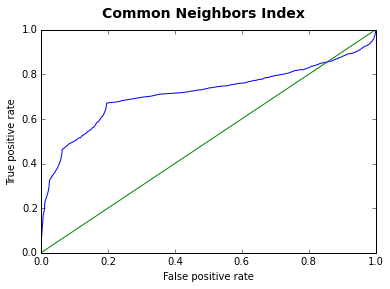

In [15]:
roc = linkprediction.ROCMetric(testGraph, dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [16]:
roc.areaUnderCurve()

0.7153109426001908

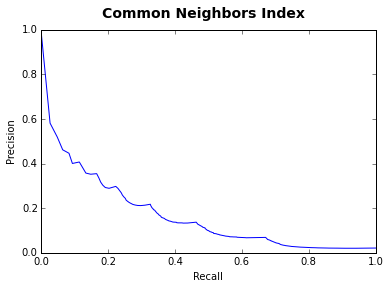

In [17]:
pr = linkprediction.PrecisionRecallMetric(testGraph, dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Common Neighbors Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [18]:
pr.areaUnderCurve()

0.16907461302366936

In [19]:
start_time = time.time()
dyadScorePairs = jaccardIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.9683644771575928 seconds


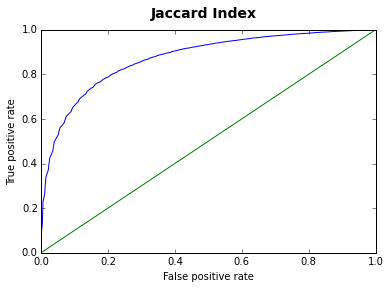

In [20]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [21]:
roc.areaUnderCurve()

0.8721625567575237

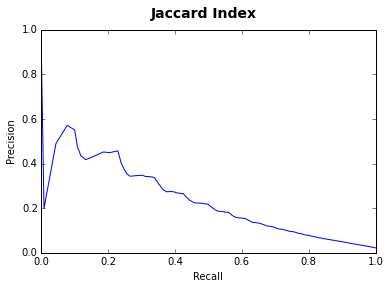

In [22]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Jaccard Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [21]:
pr.areaUnderCurve()

0.2457082057711157

In [22]:
start_time = time.time()
dyadScorePairs = preferentialAttachmentIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.47534990310668945 seconds


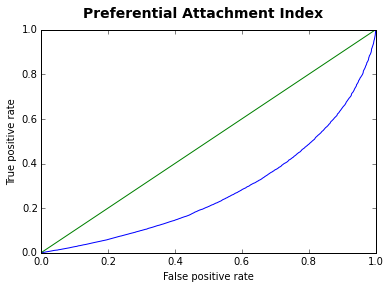

In [23]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [24]:
roc.areaUnderCurve()

0.2774959439332176

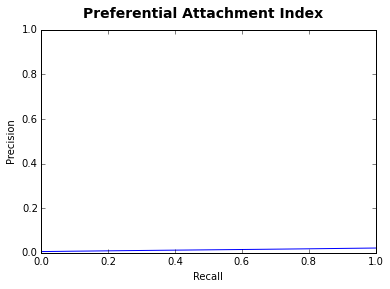

In [25]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Preferential Attachment Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [26]:
pr.areaUnderCurve()

0.013373871541683197

In [27]:
start_time = time.time()
dyadScorePairs = adamicAdarIndex.runOnParallel(missingLinks)
print("%s seconds" % (time.time() - start_time))

0.6599676609039307 seconds


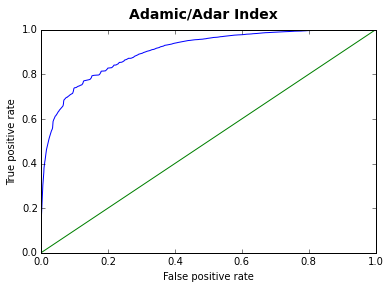

In [28]:
roc = linkprediction.ROCMetric(partitionedGraph[1], dyadScorePairs)
roc.generatePoints()
points = roc.getPoints()
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])
plt.plot([0, 1], [0, 1])

In [29]:
roc.areaUnderCurve()

0.9036966626566063

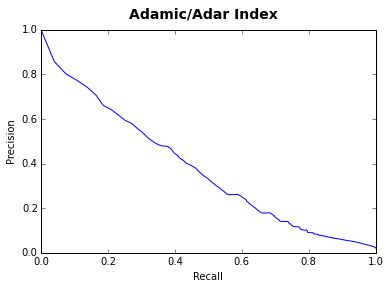

In [30]:
pr = linkprediction.PrecisionRecallMetric(partitionedGraph[1], dyadScorePairs)
pr.generatePoints()
points = pr.getPoints()
plt.suptitle("Adamic/Adar Index", fontsize=14, fontweight="bold")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.plot(points[0], points[1])

In [31]:
pr.areaUnderCurve()

0.37767454754774116

In [77]:
node = partitionedGraph[0].randomNode()
nodes = partitionedGraph[0].neighbors(node)

subGraph = graph.Subgraph().fromNodes(partitionedGraph[0], nodes)

In [78]:
LIST_LENGTH = len(nodes) - 1
a = []
color = {}
while len(a) < LIST_LENGTH:
    a.append(500)
for e in nodes:
    color[e] = len(nodes)
a.append(2000)
len(color)
color[list(color)[-1]] = len(nodes) / 2
color[list(color)[-2]] = len(nodes) / 3

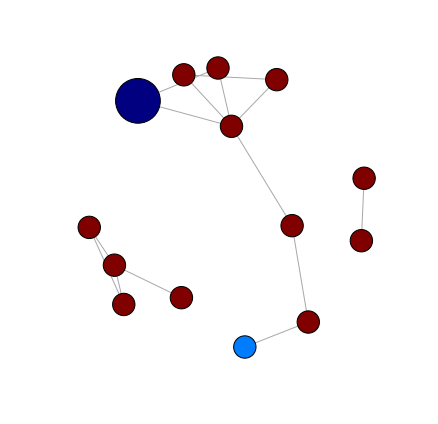

In [79]:
viztasks.drawGraph(subGraph, (7,7), False, a, None, color)

In [ ]:
crossValidator = linkprediction.KFoldCrossValidator(G, commonNeighborsIndex, roc)
crossValidator.crossValidate(10)

Traceback (most recent call last):
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 3032, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 3032, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-a162fb8f0567>", line 2, in <module>
    crossValidator.crossValidate(10)
  File "_NetworKit.pyx", line 5561, in _NetworKit.KFoldCrossValidator.crossValidate (networkit/_NetworKit.cpp:45575)
MemoryError: std::bad_alloc

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/xza/Thesis/NetworKit-Esders/env/lib/python3.4/site-packages/IPython/core/interactiveshell.py", line 1845, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'MemoryError' object has no attribute '_render_traceba

ERROR: Internal Python error in the inspect module.
Below is the traceback from this internal error.

